In [1]:
import time
import os
import torch
import torch.nn as nn
import numpy as np
from torch.optim import LBFGS
from tqdm import tqdm


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec


torch.set_default_dtype(torch.float64)
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
dtype  = torch.float64

In [2]:
class ConventBlock(nn.Module):
    def __init__(self,in_N,out_N):
        super(ConventBlock, self).__init__()
        self.Ls  = None
        self.net =nn.Sequential(nn.Linear(in_N,out_N),nn.Tanh()) 

    def forward(self, x):
        out = self.net(x)
        return out 

In [3]:
class Network(torch.nn.Module):
    def __init__(self,in_N,m,H_Layer,out_N,**kwargs):
        super(Network,self).__init__()
        self.mu  = kwargs["mean"]
        self.std = kwargs["stdev"]
            
        layers = []
        layers.append(ConventBlock(in_N,m))
        for i in range(0,H_Layer-1):
            layers.append(ConventBlock(m,m))
         # output layer
        layers.append(nn.Linear(m,out_N))
        # total layers
        self.net = nn.Sequential(*layers)
        
    def forward(self,x,t):
        data = torch.cat((x,t),dim=1);
        # normalize the input
        data = (data - self.mu)/self.std
        out  = self.net(data)
        return out
        
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight.data)
        nn.init.zeros_(m.bias)

In [4]:
def fetch_interior_data(domain,N_data):
    """
    Sampling collocation point:
    Args : 
        - domain :(numpy array) for the size of the domain
        - N_data :(int) number of points 
    out : a tensor of collocation points
    """
    dim = domain.shape[0]
    soboleng = torch.quasirandom.SobolEngine(dimension=dim,scramble=True)
    data     = soboleng.draw(N_data,dtype=dtype)*(domain[1] - domain[0]) + domain[0]
    x        = data[:,0][:,None]
    t        = data[:,1][:,None]
    return x,t

In [5]:
def fetch_init_data(domain,N_data):
    x_min    = domain[0][0]
    x_max    = domain[1][0]
    soboleng = torch.quasirandom.SobolEngine(dimension=1,scramble=True)
    x        = soboleng.draw(N_data,dtype=dtype)*(x_max - x_min) + x_min
    t        = torch.zeros_like(x)
    return x,t

In [6]:
def fetch_boundary_data(domain,N_data):
    # Left and right BC
    N_data   = N_data//2 
    
    x_min    = domain[0][0]
    x_max    = domain[1][0]
    
    t_min    = domain[0][1]
    t_max    = domain[1][1]
    
    soboleng = torch.quasirandom.SobolEngine(dimension=1,scramble=True)
    t        = soboleng.draw(N_data,dtype=dtype)*(t_max - t_min) + t_min
    
    E_bc     = torch.cat(( torch.full_like(t,x_max),t), dim = 1)
    W_bc     = torch.cat(( torch.full_like(t,x_min),t), dim = 1)
    
    data     = torch.cat((E_bc, W_bc), dim = 0)
    
    
    x        = data[:,0][:,None]
    t        = data[:,1][:,None]
    return x,t

In [7]:
def physics_loss(model,x,t):
    u       = model(x,t)
    u_x,u_t = torch.autograd.grad(u.sum(),(x,t),create_graph=True)
    u_tt    = torch.autograd.grad(u_t.sum(),t,create_graph=True)[0]
    u_xx    = torch.autograd.grad(u_x.sum(),x,create_graph=True)[0]
    f       = source(x,t)
    e       = u_tt -  u_xx + u.pow(3) - f
    loss    = e.pow(2)
    return loss

In [8]:
def boundary_loss(model,x,t):
    u       = model(x,t)
    u_e     = ue(x,t)
    e       = (u - u_e) 
    loss    = e.pow(2)
    return loss

In [9]:
def first_init_loss(model,x,t):
    u       = model(x,t)
    u_e     = ue(x,t)
    e       = (u - u_e) 
    loss    = e.pow(2)
    return loss

In [10]:
def second_init_loss(model,x,t):
    u       = model(x,t)
    u_t     = torch.autograd.grad(u.sum(),t,create_graph=True)[0]
    uet     = ue_t(x,t)
    e       = (u_t - uet)
    loss    = e.pow(2)
    return loss

$$ u_{tt}  - u_{xx} + u ^{3} = f(x,t) $$

In [11]:
pi = torch.tensor(np.pi)
def ue(x,t):
    return x * torch.cos(5. * pi * t) + (x * t).pow(3) 

def ue_t(x,t):
    return - 5.0 * pi * x * torch.sin(5. * pi * t) + 3.0 * x * (x*t).pow(2) 

def ue_tt(x,t):
    return - (5.0 * pi).pow(2) * x * torch.cos(5. * pi * t) + 6.0 * x.pow(2) * (x*t)

def ue_x(x,t):
    return torch.cos(5. * pi * t) + 3.0 * t* (x * t).pow(2)

def ue_xx(x,t): 
    return 6.0 * t.pow(2) * (x * t)

def source(x,t):
    return ue_tt(x,t) - ue_xx(x,t) + ue(x,t).pow(3) 

In [12]:
kwargs ={"mean":0.50, "stdev":0.2887}  
domain = np.array([[0.,0.],[1.,1.]])
model  = Network(in_N=2,m=50,H_Layer=5,out_N=1,**kwargs)
model.to(device)
model.apply(init_weights)
print(model)
print(model.mu)
print(model.std)

Network(
  (net): Sequential(
    (0): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=2, out_features=50, bias=True)
        (1): Tanh()
      )
    )
    (1): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=50, out_features=50, bias=True)
        (1): Tanh()
      )
    )
    (2): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=50, out_features=50, bias=True)
        (1): Tanh()
      )
    )
    (3): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=50, out_features=50, bias=True)
        (1): Tanh()
      )
    )
    (4): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=50, out_features=50, bias=True)
        (1): Tanh()
      )
    )
    (5): Linear(in_features=50, out_features=1, bias=True)
  )
)
0.5
0.2887


In [13]:
def evaluate(model,domain):
    model.eval()
    x = np.linspace(domain[0][0],domain[1][0],64)
    t = np.linspace(domain[0][1],domain[1][1],64)

    x_star,t_star = np.meshgrid(x,t)
    x_test = torch.from_numpy(x_star.flatten()[:,None])
    t_test = torch.from_numpy(t_star.flatten()[:,None])

    u_star = ue(x_test,t_test)   
    u_pred = model(x_test,t_test)
    
    l2   = np.linalg.norm(u_star- u_pred.detach(), 2)/np.linalg.norm(u_star, 2)
    linf = max(abs(u_star- u_pred.detach().numpy())).item()
    return l2,linf

In [14]:
epochs          = 1500
disp            = 500
print_to_consol = True

model.apply(init_weights)

# update the optimizer
optimizer = LBFGS(model.parameters(),line_search_fn="strong_wolfe")

# initialize penalty parameter
mu           = torch.tensor(1.0)

# maximum penalty value for safeguarding
mu_max      = torch.tensor(1e4)

# l2 norm of constraints |C|_2
eta          = torch.tensor(0.0)

# penalty tolerance
epsilon      = torch.tensor(1e-8)

# number of collocation points in the domain
N_data     = 512

# collocation points
x_dm,t_dm  = fetch_interior_data(domain,N_data)
x_dm       = x_dm.requires_grad_(True)
t_dm       = t_dm.requires_grad_(True)


N_u        = 256
# boundary points 
x_bc,t_bc  = fetch_boundary_data(domain,N_u)

N_u0       = 128

# 1st initial condition points
x_ic,t_ic  = fetch_init_data(domain,N_u0)

N_ut       = 128

# 2nd intial condition points 
x_nic,t_nic = fetch_init_data(domain,N_ut)
x_nic       = x_nic.requires_grad_(True)
t_nic       = t_nic.requires_grad_(True)

# lagrange multiplier for the boundary constraints
Lambda_u  = torch.zeros_like(x_bc)

# lagrange multiplier for the initial constraints
Lambda_ut = torch.zeros_like(x_nic)

Lambda_u0 = torch.zeros_like(x_ic)

# starting to train neural network model
for epoch in range(epochs):
    def closure():
        if torch.is_grad_enabled():
            model.train()
            optimizer.zero_grad()

        pde_loss     = physics_loss(model,x_dm,t_dm)
        u_loss       = boundary_loss(model,x_bc,t_bc)
        u0_loss      = first_init_loss(model,x_ic,t_ic)
        ut_loss      = second_init_loss(model,x_nic,t_nic)
        

        penalty      = (u_loss.T@ u_loss + \
                           ut_loss.T@ut_loss + \
                           u0_loss.T@u0_loss).sum()

        loss         = pde_loss.sum() + \
                        (Lambda_u  * u_loss).sum() + \
                        (Lambda_ut * ut_loss).sum() + \
                        (Lambda_u0 * u0_loss).sum() +\
                        0.5 * mu   * penalty

        if loss.requires_grad:
            loss.backward()
        return loss

    def _closure():
        model.eval()
        u_loss       = boundary_loss(model,x_bc,t_bc)
        u0_loss      = first_init_loss(model,x_ic,t_ic)
        ut_loss      = second_init_loss(model,x_nic,t_nic)

        penalty      =  (u_loss.T@ u_loss + \
                        ut_loss.T@ut_loss + \
                        u0_loss.T@u0_loss).sum()

        return u_loss, ut_loss, u0_loss, penalty

    optimizer.step(closure)
    u_loss, ut_loss, u0_loss,penalty = _closure()
    with torch.no_grad():
        if (torch.sqrt(penalty) >= 0.25*eta) and (torch.sqrt(penalty) > epsilon):
            mu          = min(mu*2.0, mu_max)
            Lambda_u   += mu*u_loss
            Lambda_ut  += mu*ut_loss
            Lambda_u0  += mu*u0_loss

        eta  = torch.sqrt(penalty)
    if (epoch + 1)%disp == 0 and print_to_consol:
        print(f'epoch : {epoch+1:3d}, penalty loss: {penalty.item():2.3e}')


# checkpointing the model 
torch.save(model.state_dict(),f"klein_gordon.pt")
# evaluation
l2,linf = evaluate(model,domain)
# print the l2 norms
print(f"relative l2 error :{l2:2.3e}, linf error : {linf :2.3e}")

epoch : 500, penalty loss: 6.291e-11
epoch : 1000, penalty loss: 3.375e-12
epoch : 1500, penalty loss: 1.887e-13
relative l2 error :3.716e-04, linf error : 4.682e-04


In [18]:
# https://joseph-long.com/writing/colorbars/
def colorbar(mappable,min_val,max_val):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    ticks = np.linspace(min_val, max_val, 4, endpoint=True)
    cbar = fig.colorbar(mappable, cax=cax,ticks=ticks)
    cbar.formatter.set_powerlimits((0, 0))
    plt.sca(last_axes)
    return cbar

params = {
    'text.latex.preamble': '\\usepackage{gensymb}',
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 16, # fontsize for x and y labels
    'axes.titlesize': 16,
    'font.size': 16, 
    'legend.fontsize': 16, 
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'text.usetex': False,
    'figure.figsize': [20, 3],
    'font.family': 'serif',
}
plt.rcParams.update(params)

In [19]:
model.eval()
x = np.linspace(domain[0][0],domain[1][0],100)
t = np.linspace(domain[0][1],domain[1][1],100)

x_star,t_star = np.meshgrid(x,t)
x_test = torch.from_numpy(x_star.flatten()[:,None])
t_test = torch.from_numpy(t_star.flatten()[:,None])

u_star = ue(x_test,t_test)   
u_pred = model(x_test,t_test)

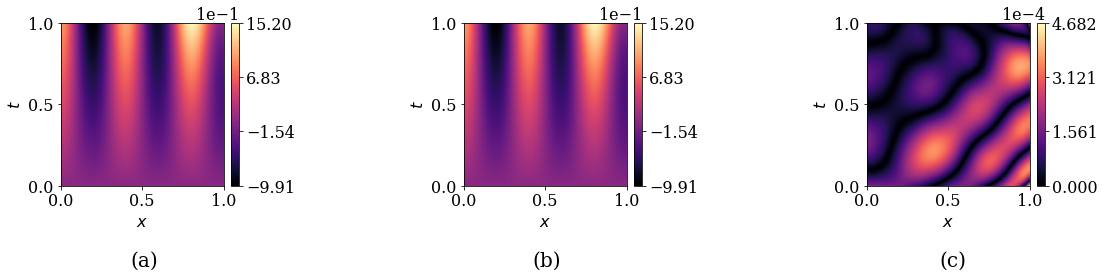

In [20]:
# ------------
# 2D figures
# --------------
cmap_list = ['jet','YlGnBu','coolwarm','rainbow','magma','plasma','inferno','Spectral','RdBu']
cmap = cmap_list[4]
gs = gridspec.GridSpec(1, 3)
gs.update(wspace=0.3)

points      = np.concatenate((x_star.flatten()[:,None],t_star.flatten()[:,None]),axis=1)
u_pred_plot = griddata(points, u_pred.detach().flatten(), (x_star,t_star), method='cubic')
u_star_plot = griddata(points, u_star.flatten(), (x_star,t_star), method='cubic')


save = True
#################################### Predicted Solution #####################################
ax = plt.subplot(gs[0,0])
min_val = np.min(u_star_plot)
max_val = np.amax(u_star_plot)
img = ax.pcolormesh(t_star,x_star,u_pred_plot, cmap = cmap,vmin=min_val,vmax=max_val,shading='gouraud')
# ax.set_title('$\hat{u}(x,y)$')
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.axis('square')
cbar = colorbar(img,min_val,max_val)
cbar.formatter.set_powerlimits((-1, -1))
ax.axis('square')
ax.set_xticks([domain[0][0],(domain[1][0]+ domain[0][0])/2,domain[1][0]])
ax.set_yticks([domain[0][1],(domain[1][1]+domain[0][1])/2,domain[1][1]])

    
# #################################### Exact Solution #########################################
ax = plt.subplot(gs[0,1])
img = ax.pcolormesh(t_star,x_star,u_star_plot, cmap = cmap,vmin=min_val,vmax=max_val,shading='gouraud')
# ax.set_title('$u(x,y)$')
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
cbar = colorbar(img,min_val,max_val)
cbar.formatter.set_powerlimits((-1, -1))
ax.axis('square')
ax.set_xticks([domain[0][0],(domain[1][0]+ domain[0][0])/2,domain[1][0]])
ax.set_yticks([domain[0][1],(domain[1][1]+domain[0][1])/2,domain[1][1]])


# #################################### Absolute Error #########################################
ax = plt.subplot(gs[0,2])
img = ax.pcolormesh(t_star,x_star,np.abs(u_star_plot - u_pred_plot), cmap = cmap,shading='gouraud')
# ax.set_title('$|u - \hat{u}|$')
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')

min_val = np.amin(np.abs(u_star_plot - u_pred_plot))
max_val = np.amax(np.abs(u_star_plot - u_pred_plot))
cbar = colorbar(img,min_val,max_val)
cbar.formatter.set_powerlimits((0, 0))
ax.axis('square')
ax.set_xticks([domain[0][0],(domain[1][0]+ domain[0][0])/2,domain[1][0]])
ax.set_yticks([domain[0][1],(domain[1][1]+domain[0][1])/2,domain[1][1]])


filename="pecanns_klein_gordon"
plt.figtext(0.229, -0.25,'(a)' ,wrap=True, horizontalalignment='center',fontsize=20)
plt.figtext(0.508, -0.25,'(b)', wrap=True, horizontalalignment='center', fontsize=20)
plt.figtext(0.790, -0.25,'(c)', wrap=True, horizontalalignment='center', fontsize=20)
plt.savefig('{}.png'.format(filename), bbox_inches='tight', pad_inches=0.02)